In [1]:
import pandas as pd
import numpy as np

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer


# Boosting classifiers
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Save model
import pickle
import joblib

In [2]:
# fileLocation = 'C:\\Users\\VictorY\\Desktop\\TestData\\stage3FinalProcessedDF_Nov-17-2019.csv'
# moviesDataFileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\Final_Data_Movies_Directors.csv'
moviesDataFileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\Movies_Directors_WithAwards.csv'


saveFileToPath = "C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\"

movies_data = pd.read_csv(moviesDataFileLocation)

In [3]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3709 entries, 0 to 3708
Columns: 142 entries, director_ids to Winner_Directing (Dramatic Picture)
dtypes: float64(27), int64(107), object(8)
memory usage: 4.0+ MB


In [43]:
object_features_to_remove = movies_data.select_dtypes(include = 'object').columns.values
object_features_to_remove

array(['director_ids', 'director_names', 'movie_id', 'title',
       'release_date', 'Gender', 'Film', 'Name'], dtype=object)

In [41]:
object_features_to_remove.tolist().remove('Gender')

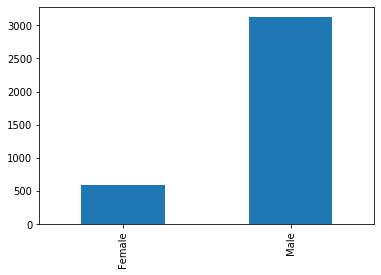

In [7]:
movies_data['Gender'].value_counts().sort_values().plot(kind = 'bar')

# Undersampling

In [122]:
movies_data.head(2)

,director_ids,director_names,movie_id,title,review_count_user,review_count_critic,metascore,rating_value,rating_count,release_date,...,Winner_Actor,Winner_Actor in a Leading Role,Winner_Actor in a Supporting Role,Winner_Actress,Winner_Actress in a Leading Role,Winner_Actress in a Supporting Role,Winner_Assistant Director,Winner_Directing,Winner_Directing (Comedy Picture),Winner_Directing (Dramatic Picture)
0,nm0000485,Fritz Lang,tt0017136,Metropolis (1927) - IMDb,418,263,98,8.3,114917,5 March 1927 (Denmark) See more »,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,nm0000122,Charles Chaplin,tt0027977,Les temps modernes (1936) - IMDb,213,119,96,8.6,147990,24 September 1936 (France) See more »,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Undersampling - Function to balance gender with random_state

In [290]:
def undersampling_balanced_gender(df,balance_feature = 'Gender', column_tobe_unique = 'director_ids'):
    
    # Shuffle the Dataset.
    shuffled_data = df.sample(frac=1,random_state=42)
    print('Unbalanced dataframe shape after undersampling :',shuffled_data.shape)

    # First remove all duplicates director_ids to have only unique columns
    unique_column_df = shuffled_data.drop_duplicates(subset = column_tobe_unique, keep='first', inplace=False)
    unique_column_df.shape
    
    # An empty balanced data frame with only the unique columns
    bal_total_unique_list_df = pd.DataFrame()
    
    # Add balanced values from all the possible classes    
    for i in unique_column_df[balance_feature].value_counts().index:
        bal_total_unique_list_df = bal_total_unique_list_df.append(unique_column_df[(unique_column_df[balance_feature]==i)]
                                                   .sample(
                                                       n= unique_column_df[balance_feature].value_counts().values.min(),
                                                       random_state = 42,
                                                       replace = False)
                                                  )
    # list of unique IDs
    total_list_unique_IDs = bal_total_unique_list_df[column_tobe_unique].to_list()
    
    balanced_data = shuffled_data[shuffled_data[column_tobe_unique].isin(total_list_unique_IDs)] 
    
    print('Balanced dataframe shape after undersampling :',balanced_data.shape)
    return balanced_data

In [291]:
balanced_data = undersampling_balanced_gender(movies_data)

Unbalanced dataframe shape after undersampling : (3709, 142)
Balanced dataframe shape after undersampling : (1320, 142)


In [271]:
balanced_data['Gender'].value_counts()

Male      735
Female    585
Name: Gender, dtype: int64

# Undersampling

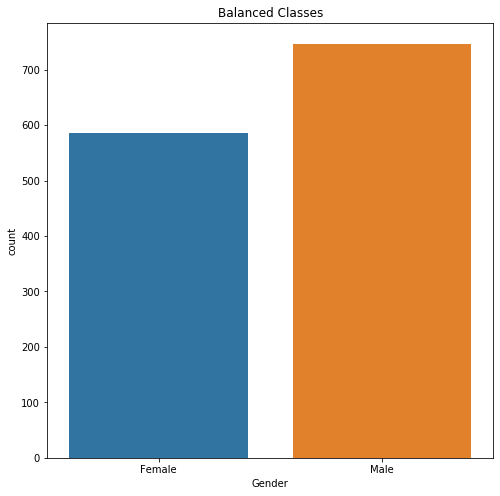

In [286]:
# Shuffle the Dataset.
shuffled_movies_data = movies_data.sample(frac=1,random_state=42)
shuffled_movies_data.shape

#Drop duplicates

shuffled_movies_data = shuffled_movies_data.drop_duplicates(subset = 'director_ids', keep='first')

# Put all the female class in a separate dataset.
female_df = shuffled_movies_data.loc[shuffled_movies_data['Gender'] == 'Female']
female_df.shape

#Randomly select equal number of male observations from the male (majority class)
male_df = shuffled_movies_data.loc[shuffled_movies_data['Gender'] == 'Male'].sample(n= female_df.shape[0] ,random_state=25)
male_df.shape

# Concatenate both dataframes again
normalized_df = pd.concat([male_df, female_df])

# list of unique IDs
total_list_unique_IDs = normalized_df['director_ids'].to_list()

balanced_data = movies_data[movies_data['director_ids'].isin(total_list_unique_IDs)] 


#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('Gender', data = balanced_data)
plt.title('Balanced Classes')
plt.show()

In [287]:
balanced_data['Gender'].value_counts()

Male      747
Female    585
Name: Gender, dtype: int64

# Ovesampling

In [32]:
from imblearn.over_sampling import SMOTE

In [33]:
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Fit the model to generate the data.

oversampled_trainX, oversampled_trainY = sm.fit_sample(movies_data.drop('Gender', axis=1), movies_data['Gender'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = normalized_df.columns

ValueError: could not convert string to float: 'nm0000485'

In [6]:
movies_data['Gender'].value_counts()

Male      3124
Female     585
Name: Gender, dtype: int64

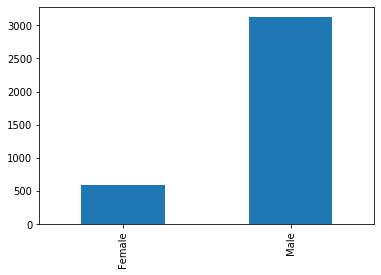

In [7]:
movies_data['Gender'].value_counts().sort_values().plot(kind = 'bar')

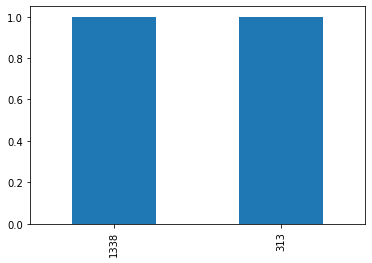

In [11]:
s = movies_data.groupby("Gender")['director_ids'].agg(lambda x:len(x.unique()))
pd.value_counts(s).plot(kind="bar")